# Optimized Neural Network

#### Import libraries and modules

In [92]:
# basics
import numpy as np
import pandas as pd

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from plotly import express as px

# sklearn preprocessing and metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix,accuracy_score, recall_score, roc_auc_score, precision_score

# tensorflow model and metrics
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras import utils
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.metrics import FalseNegatives, AUC, Precision
import visualkeras

#### Import dataMinMaxScaler

In [68]:
np.random.seed(50)

In [69]:
data = pd.read_csv('../data/clean_data.csv')

In [70]:
data.head(3)

,file_path,file_name,label,shape,0,1,2,3,4,5,...,95042,95043,95044,95045,95046,95047,95048,95049,95050,95051
0,../data/Images\Im001_ACRIMA.jpg,Im001_ACRIMA.jpg,0,"(178, 178, 3)",162,115,50,163,115,51,...,34,167,72,34,168,71,33,163,67,28
1,../data/Images\Im002_ACRIMA.jpg,Im002_ACRIMA.jpg,0,"(178, 178, 3)",144,108,56,145,109,57,...,25,145,75,26,145,75,26,146,76,27
2,../data/Images\Im003_ACRIMA.jpg,Im003_ACRIMA.jpg,0,"(178, 178, 3)",254,155,26,254,156,27,...,51,220,146,51,220,146,52,219,146,52


#### Define X and y for model

In [37]:
X = data.drop(columns=['file_path', 'file_name', 'label', 'shape'])
y = data['label']

In [38]:
# scale X data to be between 0 and 1
X = X.astype('float32')/255

In [39]:
# convert X into a numpy array where each element 
# is a figure that has the dimensions (178, 178, 3)

image_vectors = np.array(X) # each element is a vector of pixel values

X_array = np.array([row.reshape(178, 178, 3) for row in image_vectors])

X_array.shape # needs to be (705, 178, 178, 3)
              # (number of images, (pixel xy dimensions), RGB)

(705, 178, 178, 3)

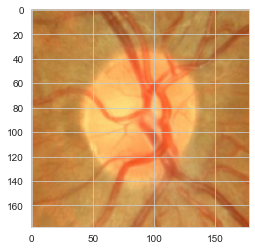

In [40]:
# Check to make sure image is not distorted
plt.imshow(X_array[0]);

In [41]:
# split into train and test sets

X_train, X_test, y_train, y_test = train_test_split(X_array, y, 
                                                    test_size=0.2, 
                                                    stratify=y, 
                                                    random_state=42)

In [95]:
# save arrays to file
# uncomment below to save train and test arrays to file as .npy

# np.save('../data/X_train.npy',X_train)
# np.save('../data/X_test.npy',X_test)
# np.save('../data/y_train.npy',y_train)
# np.save('../data/y_test.npy',y_test)

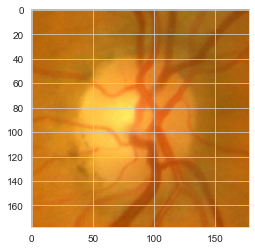

In [42]:
# checking again to make sure images are intact
plt.imshow(X_train[0]);

In [43]:
y_test

105    0
499    1
49     0
610    1
484    1
      ..
362    1
321    1
459    1
87     0
357    1
Name: label, Length: 141, dtype: int64

#### Define Model

In [71]:
# test 1: change filters for conv layer 1 from 16 to 32 --> improved recall from 0.92 to 0.98; decreased auc from 0.88 to 0.86
# test 2: change filters for conv layer 1 from 32 to 36 --> nope
# test 3: keep filters for conv layer 1 at 32, change kernal size frm (3, 3) to (4, 4) --> improved things dramatically: 
#         recall: 1.0, roc_auc: 0.9
# test 4: add second convolution layer: changed everything!! Keeping this one

cnn = Sequential()

# convolution layer 1
cnn.add(Conv2D(filters=32,
              kernel_size=(4, 4),
              activation='relu',
              input_shape=(178, 178, 3)
              ))
# pooling layer 1
cnn.add(MaxPooling2D(pool_size=(2, 2)))


# convolution layer 2
cnn.add(Conv2D(filters=32,
              kernel_size=(4, 4),
              activation='relu',
              input_shape=(178, 178, 3)
              ))
# pooling layer 2
cnn.add(MaxPooling2D(pool_size=(2, 2)))

#flatten layer
cnn.add(Flatten())

#dense layers
cnn.add(Dense(units=128, activation='relu'))

#output layer
cnn.add(Dense(units=1, activation='sigmoid'))

# early stopping
early_stop = EarlyStopping(patience=5)

# Compile model
cnn.compile(loss='bce', 
            optimizer='adam', 
            metrics=['accuracy', FalseNegatives(), Precision(), AUC()])

# Fit model on training data
history = cnn.fit(X_train, y_train,
               batch_size=256,
               epochs=20,
               validation_data=(X_test, y_test),
               callbacks=[early_stop])

Epoch 1/20
3/3 [==============================] - 11s 3s/step - loss: 1.0963 - accuracy: 0.5372 - false_negatives_3: 161.0000 - precision_3: 0.6094 - auc_3: 0.6072 - val_loss: 1.2813 - val_accuracy: 0.4397 - val_false_negatives_3: 79.0000 - val_precision_3: 0.0000e+00 - val_auc_3: 0.7602
Epoch 2/20
3/3 [==============================] - 9s 2s/step - loss: 0.9446 - accuracy: 0.6099 - false_negatives_3: 167.0000 - precision_3: 0.7389 - auc_3: 0.6247 - val_loss: 0.7519 - val_accuracy: 0.5035 - val_false_negatives_3: 70.0000 - val_precision_3: 1.0000 - val_auc_3: 0.8352
Epoch 3/20
3/3 [==============================] - 8s 2s/step - loss: 0.6357 - accuracy: 0.6436 - false_negatives_3: 199.0000 - precision_3: 0.9833 - auc_3: 0.8623 - val_loss: 0.5974 - val_accuracy: 0.7305 - val_false_negatives_3: 1.0000 - val_precision_3: 0.6783 - val_auc_3: 0.8242
Epoch 4/20
3/3 [==============================] - 8s 2s/step - loss: 0.5687 - accuracy: 0.7323 - false_negatives_3: 6.0000 - precision_3: 0.6820

In [ ]:
# uncomment below to save model to directory
# cnn.save('../models/model_03_auc93')
# visualkeras.layered_view(cnn, legend=True,to_file='../models/model_03_auc93.png').show() 